In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from copy import deepcopy

Matplotlib is building the font cache; this may take a moment.


In [2]:

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label = f'{label}, {arg}={str(kwargs[arg])}'
    p = plt.plot(x_points,energies,label=label)
    plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
    plt.legend(loc=0)

In [3]:
#this function returns the energy and force on a particle from a double well
@njit
def double_well_energy_force(x,k,a):
    return -k*x*(x-a)*(x+a)

#this function returns the energy and force on a particle from a double well
def double_well_energy(x,k,a):
    return 0.25*k*((x-a)**2) * ((x+a)**2)
#plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=1, a=2)
#plt.axhline(0,linestyle='--',color='black')
#plt.axvline(0,linestyle='--',color='black')
#plt.ylim(-10,10)



In [4]:

@njit
def position_update(x,v,dt):
    return x + v*dt/2.

#this is step B
@njit
def velocity_update(v,F,dt):
    return v + F*dt/2.

@njit
def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    return c1*v + R*c2

@njit
def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, k=1, a=1):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = [x]
    #velocities = []
    #total_energies = []
    save_times = [t]

    while (t<max_time):
        
        # B
        force = potential(x,k,a)
        v = velocity_update(v,force,dt)

        #A
        x = position_update(x,v,dt)

        #O
        v = random_velocity_update(v,gamma,kBT,dt)

        #A
        x = position_update(x,v,dt)

        # B
        force = potential(x,k,a)
        v = velocity_update(v,force,dt)

        if step_number%save_frequency == 0 and step_number>0:
            #e_total = .5*v*v + potential_energy

            positions.append(x)
            #velocities.append(v)
            #total_energies.append(e_total)
            save_times.append(t)

        t += dt
        step_number = step_number + 1

    return save_times, positions

In [5]:
my_k = 1
my_kBT = 1.0
my_a = 2.5
my_initial_position = my_a
my_initial_velocity = 0.1

my_gamma = 5
my_dt = 0.1
my_max_time = 5000000

times, positions = baoab(double_well_energy_force, my_max_time, my_dt, my_gamma, my_kBT, 
                                                     my_initial_position, my_initial_velocity,  k  = my_k, a = my_a, save_frequency=100)

<Figure size 640x480 with 0 Axes>

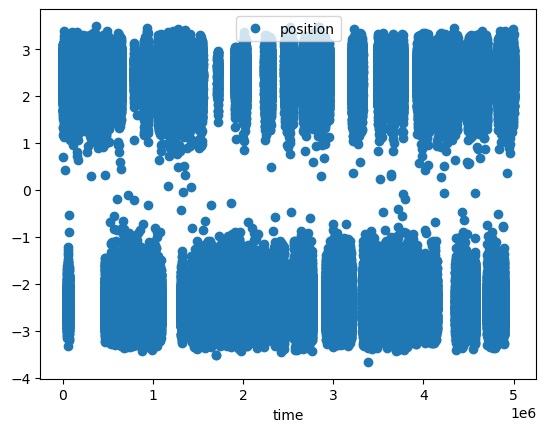

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(times,positions,marker='o',label='position',linestyle='')
#plt.plot(times,velocities,marker='s',label='velocity',linestyle='')

plt.xlabel('time')
plt.legend(loc='upper center')

plt.figure()
#initial_energy = total_energies[0]
#plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
#plt.xlabel('time')
#plt.ylabel("Total Energy")
#plt.legend()


In [7]:
def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.

def gaussian_x(x,k,kBT):
    denominator = np.sqrt(2*np.pi*kBT/k)
    numerator = np.exp(-k*(x**2)/(2*kBT))
    return numerator/denominator

def gaussian_v(v,kBT):
    denominator = np.sqrt(2*np.pi*kBT)
    numerator = np.exp(-(v**2)/(2*kBT))
    return numerator/denominator

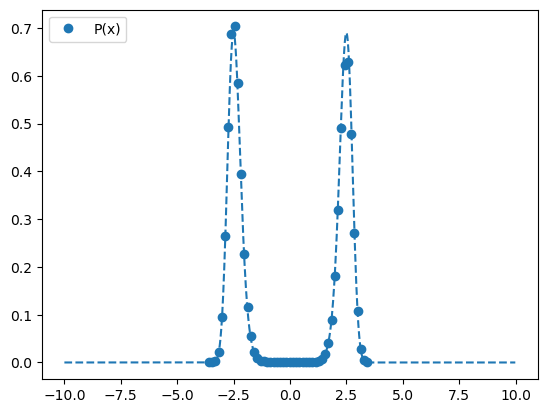

In [8]:

# histogramming the results
plt.figure()

dist_hist, dist_bin_edges = np.histogram(positions,bins=50,density=True)
#vel_hist, vel_bin_edges = np.histogram(velocities,bins=25,density=True)

p = plt.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')

#test against exact prediction
dd = 0.01
test_bin_positions = np.arange(-10,10,dd)
double_well_energies = double_well_energy(test_bin_positions,my_k,my_a)

plt.plot(test_bin_positions, np.exp(-double_well_energies/my_kBT)/np.sum(dd*np.exp(-double_well_energies/my_kBT)),\
     linestyle='--',color=p[0].get_color())

#p = plt.plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
#ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
#plt.plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())


plt.legend(loc='upper left')

(0.0, 10.0)

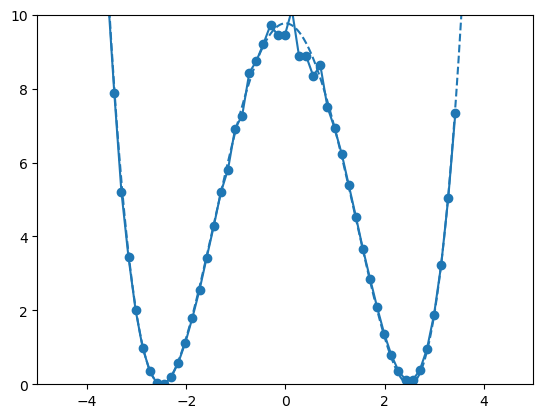

In [9]:
plt.plot(bin_centers(dist_bin_edges), -np.log(dist_hist) - np.min(-np.log(dist_hist)),marker='o',label='P(x)',linestyle='-')
plt.plot(test_bin_positions, (double_well_energies/my_kBT), linestyle='--',color=p[0].get_color())
plt.xlim([-5, 5])
plt.ylim(0, 10)

In [10]:
t, x = baoab(double_well_energy_force, 0.5, 0.1, 5, my_kBT, 
                                                     1.0, 0.7,  k  = my_k, a = my_a, save_frequency=1)

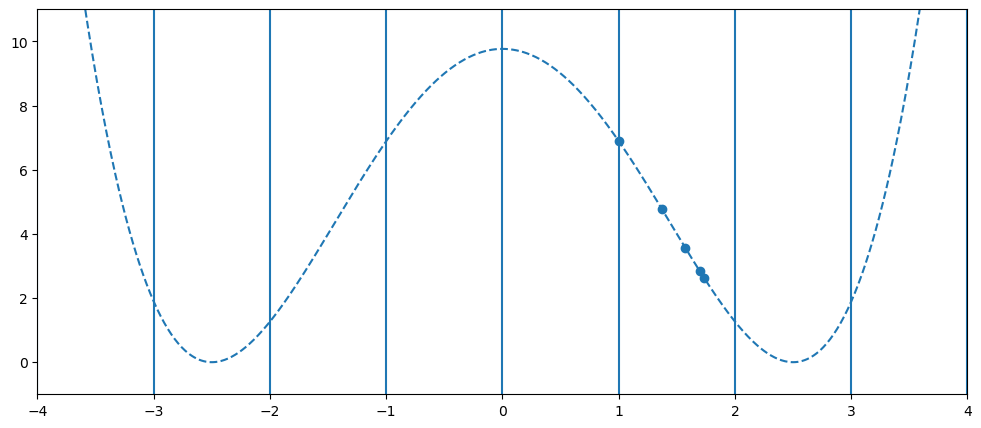

In [11]:
plt.figure(figsize=[12, 5])
plt.plot(test_bin_positions, (double_well_energies/my_kBT), linestyle='--',color=p[0].get_color())
plt.xlim([-4, 4])
plt.ylim(-1, 11)
for i in range(-4, 5):
    plt.axvline(x =i)
plt.scatter(x, double_well_energy(np.array(x), my_k, my_a))

In [12]:
inp = -2.0
traj = []
inv = np.random.normal(size = 50)
for i in range(10):
    t, x = baoab(double_well_energy_force, 1, 0.1, 5, my_kBT, 
                                                     inp, inv[i],  k  = my_k, a = my_a, save_frequency=1)
    traj.append(x)

In [13]:
def trajectory_thrower(init_p):
    traj = []
    inv = np.random.normal(size = 10)
    for i in range(10):
        t, x = baoab(double_well_energy_force, 0.5, 0.1, 5, my_kBT, 
                                                     init_p[i], inv[i],  k  = my_k, a = my_a, save_frequency=1)
        traj.append(x)
    return traj

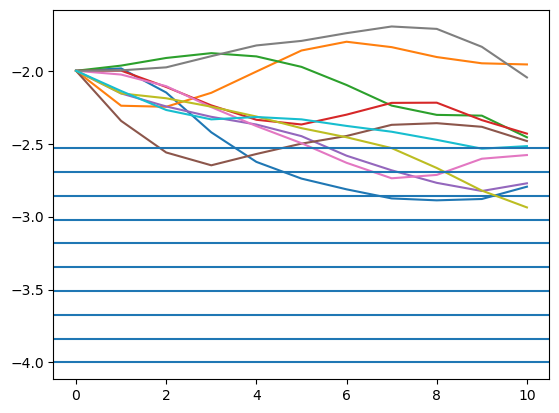

In [14]:
bins = np.linspace(-4, 4, 50)
for i in range(10):
    plt.plot(traj[i])
    plt.axhline(bins[i])

In [15]:
def bin_vacant(i, my_dict):
    return not len(my_dict[f"{i}"]["pos"])

In [16]:
def assign_bin(bins, fp):
    for i in range(49):
        if bins[i] < fp < bins[i+1]:
            return i

In [17]:
def initiate_dict():
    mydict = {f"{i}": {} for i in range(50)}
    for i in range(50):
        mydict[f"{i}"]['pos'] =  []#[None]*10
        mydict[f"{i}"]['weight'] = []#[0.0]*10
    return mydict

In [18]:
def resample(bin, old_dict):
    """
    Resamples a bin to a new dictionary
    """
    temp = deepcopy(old_dict)
    if not bin_vacant(bin, old_dict):
        num_traj_aval = len(temp[f'{bin}']['pos'])
        indx_traj_aval = np.arange(num_traj_aval)
        if num_traj_aval <= 10:
            select_split = np.random.choice(indx_traj_aval)
            for _ in range(num_traj_aval, 10):
                temp[f'{bin}']['pos'].append(temp[f'{bin}']['pos'][select_split])
                temp[f'{bin}']['weight'].append(temp[f'{bin}']['weight'][select_split]/(11 - num_traj_aval))
            temp[f'{bin}']['weight'][select_split] = temp[f'{bin}']['weight'][select_split]/(11 - num_traj_aval)
        else:
            extra = int(num_traj_aval - 10)

            for i in range(extra):
                merge = int((num_traj_aval - i) *np.random.random())
                purge = merge
                while merge != purge:
                    purge = int((num_traj_aval - i) *np.random.random())
                
                temp[f'{bin}']['weight'][merge] +=  temp[f'{bin}']['weight'][purge]
                temp[f'{bin}']['pos'].remove(temp[f'{bin}']['pos'][purge])
                temp[f'{bin}']['weight'].remove(temp[f'{bin}']['weight'][purge])
            #all_index = np.random.choice(np.arange(num_traj_aval), size = 2*extra, replace = False)
            #purge_index = all_index[:extra] 
            #merge_index = all_index[extra:]
            #for i in range(extra):
            #    temp[f'{bin}']['weight'][merge_index[i]] +=  temp[f'{bin}']['weight'][purge_index[i]]
            #for i in range(extra):
            #    temp[f'{bin}']['pos'].remove(temp[f'{bin}']['pos'][purge_index[i]])
            #    temp[f'{bin}']['weight'].remove(temp[f'{bin}']['weight'][purge_index[i]])
                #for _ in range(num_traj_aval - 10):
                #purge_index = np.random.randint(len(temp[f'{bin}']['pos']))
                #purge_weight = temp[f'{bin}']['weight'][purge_index]
                #temp[f'{bin}']['pos'].remove(temp[f'{bin}']['pos'][purge_index])
                #temp[f'{bin}']['weight'].remove(temp[f'{bin}']['weight'][purge_index])
                #merge_index = np.random.randint(len(temp[f'{bin}']['pos']))
                #temp[f'{bin}']['weight'][merge_index] += purge_weight
            #print("Merge!")
    return temp

In [19]:
####  trajecctory_thrower
def resampler(temp_dict):
    temp2 = deepcopy(temp_dict)
    bin_traj = {}
    for i in range(50):
        if np.sum(temp2[str(i)]['weight']):
            init_pos = temp2[str(i)]['pos']
            bin_traj[i] = trajectory_thrower(init_pos)
        else:
            bin_traj[i] = []

    ##Bin creation
    bin_list = []
    weight_list = []
    pos_list = []
    for i in range(50):

        if len(bin_traj[i]):
            for j in range(10):     
                final_bin = assign_bin(bins, bin_traj[i][j][-1])
                bin_list.append(final_bin)
                pos_list.append(bin_traj[i][j][-1])
                weight_list.append(temp2[str(i)]['weight'][j])
        else:
            for _ in range(10):
                final_bin = i
                #bin_list.append(final_bin)
    ## Dict updated
    test_dict = initiate_dict()
    for b, p, w  in zip(bin_list, pos_list, weight_list):
        test_dict[f'{b}']['pos'].append(p)
        test_dict[f'{b}']['weight'].append(w)

    ## Resample
    temp2 = test_dict
    for i in range(50):
        temp2 = resample(i, temp2)
    return temp2

In [20]:
old_dict = initiate_dict()
for i in range(10):
    mb = assign_bin(bins, traj[i][-1])
    old_dict[str(mb)]['pos'].append(traj[i][-1])
    old_dict[str(mb)]['weight'].append(0.1)
temp = old_dict
for i in range(50):
    temp = resample(i, temp)
new_temp = resampler(temp)    
for _ in range(10000):
    new_temp = resampler(new_temp)